We need to install the leafmap client for data visualization in the notebook.

**Note:** This is set to run silently so you will not see an output when executing this cell. If you'd like to ensure the package downloads successfully remove the `--quiet` flag

In [1]:
pip install leafmap pystac_client --quiet

Note: you may need to restart the kernel to use updated packages.


Import the python libraries required for running the script

In [2]:
import json
import leafmap
import stackstac
import xarray as xr

from pystac_client import Client

This is a dictionary where we define several sample cases to show the capabilities of the HLS data for various applications. These configuration settings will automatically set the location of the map for AOI selection and the start_date and end_date to perform the data query.

In [26]:
#configure settings for selected events
EVENT_DETAILS = {
    'pakistan_flood': {
        'center_lon': 68.3,
        'center_lat': 26.4,
        'default_zoom': 10,
        'start_date': '2022-09-01T00:00:00Z',
        'end_date': '2022-09-17T00:00:00Z'
    },
    'mongolian_fire': {
        'center_lon': 119.3,
        'center_lat': 47.1,
        'default_zoom': 8,
        'start_date': '2022-04-19T00:00:00Z',
        'end_date': '2022-04-19T23:59:59Z'
    },
    'mississippi_tornado': {
        'center_lon': -89.9,
        'center_lat': 33.4,
        'default_zoom': 14,
        'start_date': '2023-02-19T00:00:00Z',
        'end_date': '2023-04-20T23:59:59Z'
    },
    'new_mexico_black_fire': {
        'center_lon': -107.5,
        'center_lat': 33.5,
        'default_zoom': 10,
        'start_date': '2022-05-16T00:00:00Z',
        'end_date': '2022-06-10T23:59:59Z'
    },
    'lake_tahoe_snow': {
        'center_lon': -120.0,
        'center_lat': 39.1,
        'default_zoom': 9,
        'start_date': '2023-04-06T00:00:00Z',
        'end_date': '2023-04-06T23:59:59Z'
    },
    'alberta_fire': {
        'center_lon': -124.2,
        'center_lat': 61.8,
        'default_zoom': 8,
        'start_date': '2023-05-27T00:00:00Z',
        'end_date': '2023-05-28T23:59:59Z'
    },

}

Select the predefined event of your choice from above. If you'd like to execute a different event, the simplest way to implement it would be to add the event details as a new key in the dictionary

In [17]:
event = 'lake_tahoe_snow'
event_details = EVENT_DETAILS[event]

Initialize map with one of the canned examples listed above. If you would like execute a custom use case, please navigate to your desired AOI, draw a bounding box, and update the start_date and end_date in the prepare_items method

In [15]:
map = leafmap.Map(center=(event_details['center_lat'],event_details['center_lon']), zoom=event_details['default_zoom'], 
                draw_control=True, measure_control=False, fullscreen_control=False, attribution_control=True)

map

Map(center=[39.1, -120.0], controls=(AttributionControl(options=['position', 'prefix'], position='bottomright'…

This cell saves the bounding box drawn by the user.

**WARNING:** if you skip the next step, the notebook will not find any HLS data as there will be no bounding box information.

In [18]:
# Save the selected location as geojson
map.save_draw_features("bbox.geojson")

**WARNING:** if you skipped the previous step, the notebook will not find any HLS data as there will be no bounding box information.

In [19]:
# Read the bounding box and print
bbox = json.load(open("bbox.geojson", "r"))
bbox

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-120.508604, 38.711417],
      [-120.508604, 39.487267],
      [-119.577513, 39.487267],
      [-119.577513, 38.711417],
      [-120.508604, 38.711417]]]}}]}

In [20]:
# Establish Connection with eoAPI

api = Client.open("https://e011yr04a1.execute-api.us-west-2.amazonaws.com")
api.title

'eoAPI-stac'

In [8]:
def prepare_items(event, collection_name, bbox, start_date=None, end_date=None):
    """
    Prepare stack based on the selected event, datetime, and collection type
    ARGS:
        event (str): Name of event, any key from EVENT_DETAILS
        collection_name (str): One of [HLSS30, HLSL30]
        bbox (list): List of bounding box coordinates (in geojson format).
        start_date (str): optional, start_date if custom date range
        start_date (str): optional, end_date if custom date range
    """
    if not(start_date) or not(end_date):
        start_date = EVENT_DETAILS[event]['start_date']
        end_date = EVENT_DETAILS[event]['end_date']
    results = api.search(
        intersects=bbox["features"][0]["geometry"],
        datetime=f"{start_date}/{end_date}",
        collections=[collection_name]
    )
    items = results.item_collection()
    for item in results.items():
        print(item.id)
    return items

def prepare_stack(items, desired_product, collection_name):
    stack = stackstac.stack(
        items,
        epsg='EPSG:4326',
        rescale=True,
        assets=DERIVED_PRODUCTS[desired_product][collection_name],
    )
    return stack

This is setting up another set of methods to preprocess the data (applying the scale factor) and the equations for calculating the various indices and RGB combinations.

In [9]:
def preprocess(band_stack):
    """
    Preprocess provided band stack/rescale.
    """
    return band_stack.where(band_stack != -9999) * .0001

def calculate_NDVI(items, band1_name, band2_name, product, collection_name):
    """
    Calculate NDVI with NIR and RED bands:
    Args:
        band1_name: NIR band name for the stack
        band2_name: Red band name for the stack
    return:
        ndvi stack
    """
    stack = prepare_stack(items, product, collection_name)
    band1, band2 = stack.sel(band=band1_name), stack.sel(band=band2_name)
    ndvi = (band1 - band2) / (band1 + band2)
    ndvi = ndvi.persist()
    return ndvi

def calculate_EVI(items, band1_name, band2_name, band3_name, collection_name):
    """
    Calculate ...
    Args:
        band1_name: NIR band name for the stack
        band2_name: Red band name for the stack
        band3_name: NIR band name for the stack
    return:
        EVI stack
    """
    stack = prepare_stack(items, 'EVI', collection_name)
    band1, band2, band3 = stack.sel(band=band1_name), stack.sel(band=band2_name), stack.sel(band=band3_name)
    evi = 2.5 * ((band1 - band2) / (band1 + 6.0 * band2 - 7.5 * band3 + 1.0))
    evi = evi.persist()
    return evi

def calculate_SAVI(items, band1_name, band2_name, collection_name):
    """
    Calculate ...
    Args:
        band1_name: NIR band name for the stack
        band2_name: Red band name for the stack
    return:
        SAVI stack
    """
    stack = prepare_stack(items, 'EVI', collection_name)
    band1, band2 = stack.sel(band=band1_name), stack.sel(band=band2_name)
    savi = ((band1 - band2) / (band1 + band2 + 0.5)) * 1.5
    savi = savi.persist()
    return savi

def calculate_MSAVI(items, band1_name, band2_name, collection_name):
    """
    Calculate ...
    Args:
        band1_name: NIR band name for the stack
        band2_name: Red band name for the stack
    return:
        MSAVI stack
    """
    stack = prepare_stack(items, 'MSAVI', collection_name)
    band1, band2 = stack.sel(band=band1_name), stack.sel(band=band2_name)
    msavi = (2.0 * band1 + 1.0 - np.sqrt((2.0 * band1 + 1.0)**2.0 - 8.0 * (band1 - band2))) / 2.0
    msavi = msavi.persist()
    return msavi

def calculate_TVI(items, band1_name, band2_name, band3_name, collection_name):
    """
    Calculate ...
    Args:
        band1_name: NIR band name for the stack
        band2_name: Red band name for the stack
        band3_name: NIR band name for the stack
    return:
        TVI stack
    """
    stack = prepare_stack(items, 'TVI', collection_name)
    band1, band2, band3 = stack.sel(band=band1_name), stack.sel(band=band2_name), stack.sel(band=band3_name)
    tvi = 0.5 * (120. * (band1 - band2) - 200. * (band3 - band2))
    tvi = tvi.persist()
    return tvi

def scale_RGB(items, band1_name, band2_name, band3_name, index, collection_name):
    """
    Prepare a True color composite based on the list of bands passed.
    Args:
        band1_name: NIR band name for the stack
        band2_name: Red band name for the stack
        band3_name: NIR band name for the stack
    return:
        TVI stack

    """
    stack = prepare_stack(items, index, collection_name)
    rgb = stack.sel(band=[band1_name, band2_name, band3_name])
    rgb.persist()
    return rgb

This dictionary establishes the configuration for the various derived index/RGB combination. Each index/RGB combination includes the desired bands for both HLSL30 and HLSS30 data products as well as the execution equation for extracting the desired information.

In [10]:
# Define all related data.
DERIVED_PRODUCTS = {
    "NDVI":{
        "HLSS30": ["B8A","B04"],
        "HLSL30": ["B05","B04"],
        "exec": calculate_NDVI
    },
    "EVI":{
        "HLSS30": ["B8A", "B04", "B02"],
        "HLSL30": ["B05", "B04", "B02"],
        "exec": calculate_EVI
    },
    "SAVI":{
        "HLSS30": ["B8A", "B04"],
        "HLSL30": ["B05", "B04"],
        "exec": calculate_SAVI
    },
    "MSAVI":{
        "HLSS30": ["B8A", "B04"],
        "HLSL30": ["B05", "B04"],
        "exec": calculate_MSAVI
    },
    "NDMI":{
        "HLSS30": ["B8A", "B11"],
        "HLSL30": ["B05", "B06"],
        "exec": calculate_NDVI
    },
    "NBR":{
        "HLSS30": ["B8A", "B12"],
        "HLSL30": ["B05", "B07"],
        "exec": calculate_NDVI
    },
    "NBR2":{
        "HLSS30": ["B11", "B12"],
        "HLSL30": ["B06", "B07"],
        "exec": calculate_NDVI        
    },
    "NDWI":{
        "HLSS30": ["B03", "B8A"],
        "HLSL30": ["B03", "B05"],
        "exec": calculate_NDVI
    },
    "MNDWI1":{
        "HLSS30": ["B03", "B11"],
        "HLSL30": ["B03", "B06"],
        "exec": calculate_NDVI
    },
    "MNDWI2":{
        "HLSS30": ["B03", "B12"],
        "HLSL30": ["B03", "B07"],
        "exec": calculate_NDVI
    },
    "NDSI":{
        "HLSS30": ["B03", "B11"],
        "HLSL30": ["B03", "B06"],
        "exec": calculate_NDVI
    },
    "TVI":{
        "HLSS30": ["B8A", "B03", "B04"],
        "HLSL30": ["B05", "B03", "B04"],
        "exec": calculate_TVI
    },
    "TC":{
        "HLSS30": ["B04", "B03", "B02"],
        "HLSL30": ["B04", "B03", "B02"],
        "exec": scale_RGB
    },
    "SWIR":{
        "HLSS30": ["B12", "B8A", "B04"],
        "HLSL30": ["B07", "B05", "B04"],
        "exec": scale_RGB
    },
}

This cell extracts the data from the data granules, extracts the desired output for the `index` provided. It then calls on the `DERIVED_PRODUCTS` dictionary above to grab the required bands for each HLS product and equation given by `exec` in the dictionary.

In [32]:
import gc
gc.collect()
def calculate_index(event, index, hls_products):
    index_array = {}
    for product in hls_products:
        items = prepare_items(event, product, bbox)
        if len(items) == 0:
            print(f"No items available for this location and time for {product}")
            continue
        indices = DERIVED_PRODUCTS[index]['exec'](items, *DERIVED_PRODUCTS[index][product], index, product)
        index_array[product] = indices.resample(time="1d").max()[0]
    return index_array


# Calculate derived index for the selected location and date
index = 'NDSI' # TC/SWIR for RGB combination
hls_products = ['HLSL30','HLSS30']
index_array = calculate_index(event, index, hls_products)

HLS.L30.T11SKC.2023096T183315.v2.0
HLS.L30.T10SGJ.2023096T183315.v2.0
HLS.L30.T10SGH.2023096T183315.v2.0
HLS.L30.T11SKD.2023096T183251.v2.0
HLS.S30.T10SGH.2023096T183921.v2.0
HLS.S30.T11SKC.2023096T183921.v2.0
HLS.S30.T10SGJ.2023096T183921.v2.0
HLS.S30.T11SKD.2023096T183921.v2.0


The next two plots can be used to visualize HLS-derived band indices (e.g. NDVI, NDWI, NBR, etc.). 

*Note if the plots do not show up, please ensure there is data for either HLSL30 or HLSS30 and the index is not TC or SWIR. TC and SWIR correspond to RGB imagery and not indices.

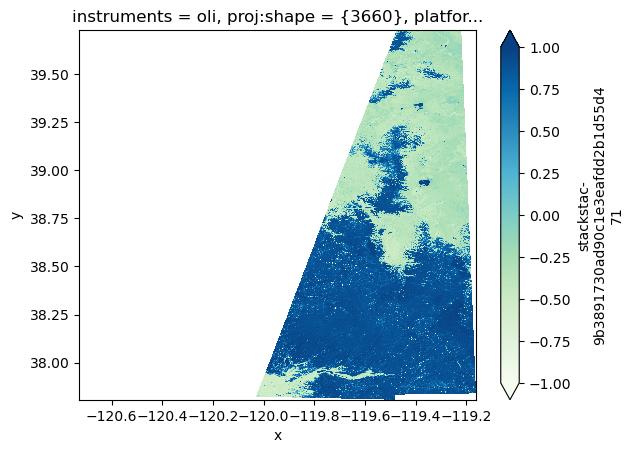

In [33]:
# Visually see the derived index using L30 for selected location, and date.
if "HLSL30" in index_array.keys() and index not in ["TC", "SWIR"]:
    index_array["HLSL30"].plot(vmin=-1, vmax=1, cmap="GnBu")

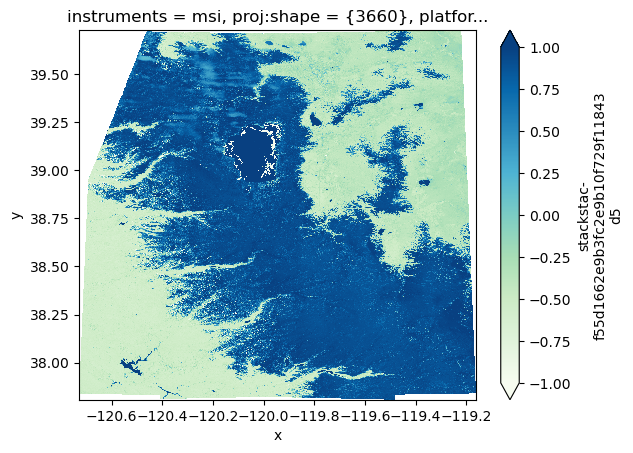

In [34]:
# Visually see the derived index using S30 for selected location, and date.
if "HLSS30" in index_array.keys() and index not in ["TC", "SWIR"]:
    index_array["HLSS30"].plot(vmin=-1, vmax=1, cmap="GnBu")

The next two plots can be used to visualize RGB band combinations (e.g. True Color (TC) and Shortwave IR (SWIR) false color composite)

*Note if the plots do not show up, please ensure there is data for either HLSL30 or HLSS30 and the index is set to either TC or SWIR. TC and SWIR are the only options that correspond to RGB imagery we plot below.

In [35]:
# plot L30 RGB
if "HLSL30" in index_array.keys() and index in ["TC", "SWIR"]:
    index_array["HLSL30"].plot.imshow(rgb="band", robust=True);

In [36]:
# plot S30 RGB
if "HLSS30" in index_array.keys() and index in ["TC", "SWIR"]:
    index_array["HLSS30"].plot.imshow(rgb="band", robust=True);